In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

# Step 1: Generate random images
def generate_random_images(num_images=10, img_size=(128, 128)):
    images = []
    for _ in range(num_images):
        img = np.random.randint(0, 256, img_size + (3,), dtype=np.uint8)
        images.append(img)
    return np.array(images)


In [ ]:
# Step 2: Simple function to embed watermark (LSB method)
def embed_watermark(image, watermark_code):
    binary_code = ''.join(format(ord(i), '08b') for i in watermark_code)  # Convert code to binary
    binary_code = list(map(int, binary_code))  # Convert to a list of integers

    h, w, _ = image.shape
    flat_image = image.flatten()

    # Replace LSB of the pixels with watermark bits
    for i in range(len(binary_code)):
        flat_image[i] = (flat_image[i] & 254) | binary_code[i]

    watermarked_image = flat_image.reshape(h, w, 3)
    return watermarked_image

In [ ]:
# Step 3: Build Generator for watermarking
def build_generator(img_shape):
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=img_shape))
    model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Conv2D(3, kernel_size=3, padding="same"))  # Output image with embedded watermark
    return model

In [ ]:
# Step 4: Build Discriminator to detect watermark
def build_discriminator(img_shape):
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=img_shape))
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
# Step 5: Compile the GAN model
def build_gan(generator, discriminator):
    discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(128, 128, 3))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan_model = tf.keras.Model(gan_input, gan_output)
    gan_model.compile(loss="binary_crossentropy", optimizer="adam")
    return gan_model

In [ ]:
# Step 6: Post-processing attacks (Gaussian Blur and JPEG Compression)
def apply_attack(image):
    attacked_image = cv2.GaussianBlur(image, (5, 5), 0)  # Gaussian Blur
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90]  # JPEG Compression
    result, encimg = cv2.imencode('.jpg', attacked_image, encode_param)
    attacked_image = cv2.imdecode(encimg, 1)
    return attacked_image


In [ ]:
# Step 7: Train the GAN
def train_gan(generator, discriminator, gan_model, dataset, epochs=5000, batch_size=32):
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, dataset.shape[0], batch_size)
        real_images = dataset[idx]

        # Generate watermarked images
        generated_images = generator.predict(real_images)
         # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)

        # Train the generator
        g_loss = gan_model.train_on_batch(real_images, real_labels)

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | D Loss Real: {d_loss_real[0]} | D Loss Fake: {d_loss_fake[0]} | G Loss: {g_loss}")

In [ ]:
# Step 8: Visualize results
def visualize_results(generator, dataset, watermark_code):
    random_idx = np.random.randint(0, len(dataset))
    original_image = dataset[random_idx]

    # Embed watermark
    watermarked_image = generator.predict(np.expand_dims(original_image, axis=0))[0]

    attacked_image = apply_attack(watermarked_image)

    # Display images
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(watermarked_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Watermarked: {watermark_code}")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(attacked_image, cv2.COLOR_BGR2RGB))
    plt.title("Attacked Image")

    plt.show()

In [ ]:
# Main function to run the watermarking process
if __name__ == "__main__":
    # Load random images
    dataset = generate_random_images(num_images=100)

    # Define image shape
    img_shape = (128, 128, 3)

    # Define watermark code
    watermark_code = "2345643"

    # Build the generator and discriminator
    generator = build_generator(img_shape)
    discriminator = build_discriminator(img_shape)
    gan_model = build_gan(generator, discriminator)
     # Train the GAN
    train_gan(generator, discriminator, gan_model, dataset, epochs=201, batch_size=16)

1/1 [==============================] - 0s 107ms/step
Epoch 0 | D Loss Real: 12.898765563964844 | D Loss Fake: 44.265411376953125 | G Loss: 2.6100654501744723e-14
1/1 [==============================] - 0s 75ms/step
Epoch 100 | D Loss Real: 0.0 | D Loss Fake: 3.547116018554674e-25 | G Loss: 8.815391540527344
1/1 [==============================] - 0s 74ms/step
Epoch 200 | D Loss Real: 0.0 | D Loss Fake: 387.17724609375 | G Loss: 0.0


1/1 [==============================] - 0s 29ms/step


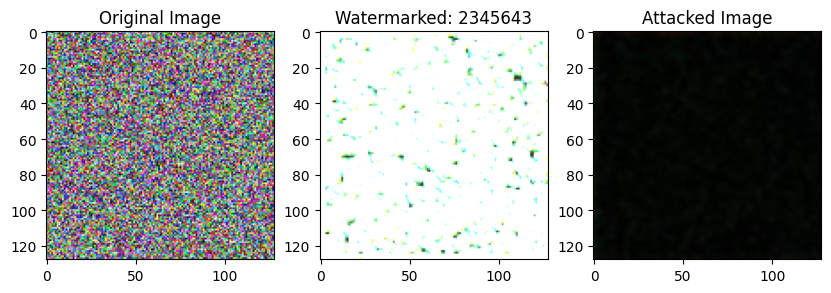

In [ ]:
# Visualize result
visualize_results(generator, dataset, watermark_code)